## Finding Your Way In The City

In this notebook you'll combine the work of previous exercises to calculate a minimal series of waypoints in order to get from a start location to a goal location.

You'll reuse and modify your algorithms from:

- A*
- Configuration Space
- Collinearity and/or Bresenham

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from grid import create_grid
from planning import a_star

%matplotlib inline

#from bresenham import bresenham

In [2]:
plt.rcParams['figure.figsize'] = 12, 12

You'll notice we've imported `create_grid`, and `a_star`. These are functions you've implemented in previous exercises, and here you'll use them to create a map and find a path from a starting position to a goal position.

To read the function signature and documentation execute `?` followed by the function name in a cell. In the example below we'll check the documentation for `create_grid`.

In [17]:
?create_grid

If you would like to alter these implementations, you can modify [grid.py](/edit/grid.py) and [planning.py](/edit/planning.py) in the current directory.

In [4]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ..., 
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [5]:
# Static drone altitude (meters)
drone_altitude = 5

# Minimum distance stay away from obstacle (meters)
safe_distance = 3

In [18]:
# TODO: Use `create_grid` to create a grid configuration space of
# the obstacle data.
grid = create_grid(data, drone_altitude, safe_distance)

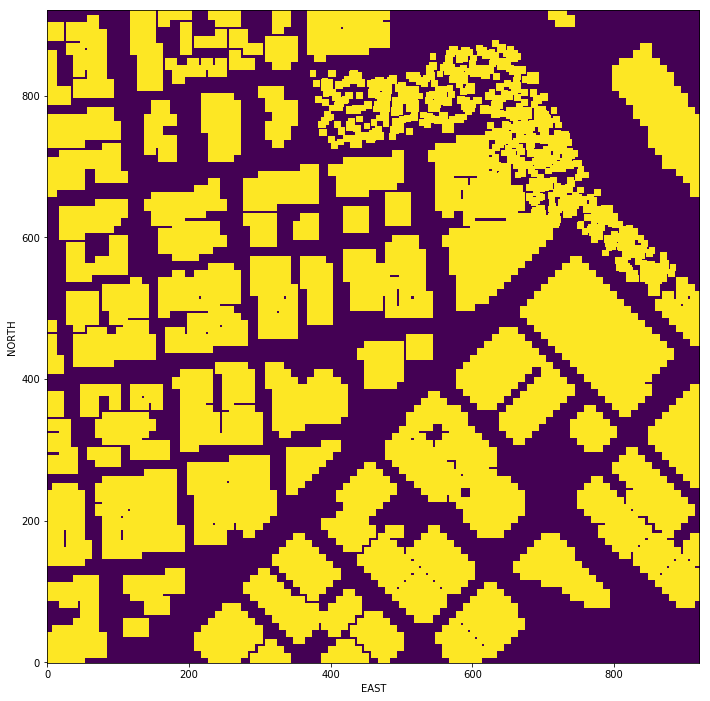

In [19]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower') 

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Next you'll compute the path from a start location to a goal location using A*.

Start and goal coordinates in *(north, east)*.

In [20]:
start_ne = (25,  100)
goal_ne = (750., 370.)

Write a heuristic function.

In [21]:
def heuristic_func(position, goal_position):
    # TODO: write a heuristic!
    x_cost = abs(goal_position[0] - position[0])
    y_cost = abs(goal_position[1] - position[1])
    h = x_cost + y_cost
    return h

Compute the lowest cost path with `a_star`. 

In [24]:
# TODO: use `a_star` to compute the lowest cost path
path, cost = a_star(grid, heuristic_func, start_ne, goal_ne)
print(path, cost)

Found a path.
[(25, 100), (25, 101), (25, 102), (25, 103), (25, 104), (25, 105), (25, 106), (25, 107), (25, 108), (25, 109), (25, 110), (25, 111), (25, 112), (25, 113), (25, 114), (25, 115), (25, 116), (25, 117), (25, 118), (25, 119), (25, 120), (25, 121), (25, 122), (25, 123), (25, 124), (25, 125), (25, 126), (25, 127), (25, 128), (25, 129), (25, 130), (25, 131), (25, 132), (25, 133), (25, 134), (25, 135), (25, 136), (25, 137), (25, 138), (25, 139), (25, 140), (25, 141), (25, 142), (25, 143), (25, 144), (25, 145), (25, 146), (25, 147), (25, 148), (25, 149), (25, 150), (25, 151), (25, 152), (25, 153), (25, 154), (25, 155), (25, 156), (25, 157), (25, 158), (25, 159), (25, 160), (25, 161), (25, 162), (25, 163), (25, 164), (25, 165), (25, 166), (25, 167), (25, 168), (25, 169), (25, 170), (25, 171), (25, 172), (25, 173), (25, 174), (25, 175), (25, 176), (25, 177), (25, 178), (25, 179), (25, 180), (25, 181), (25, 182), (25, 183), (25, 184), (25, 185), (25, 186), (25, 187), (25, 188), (25, 1

Let's plot the path!

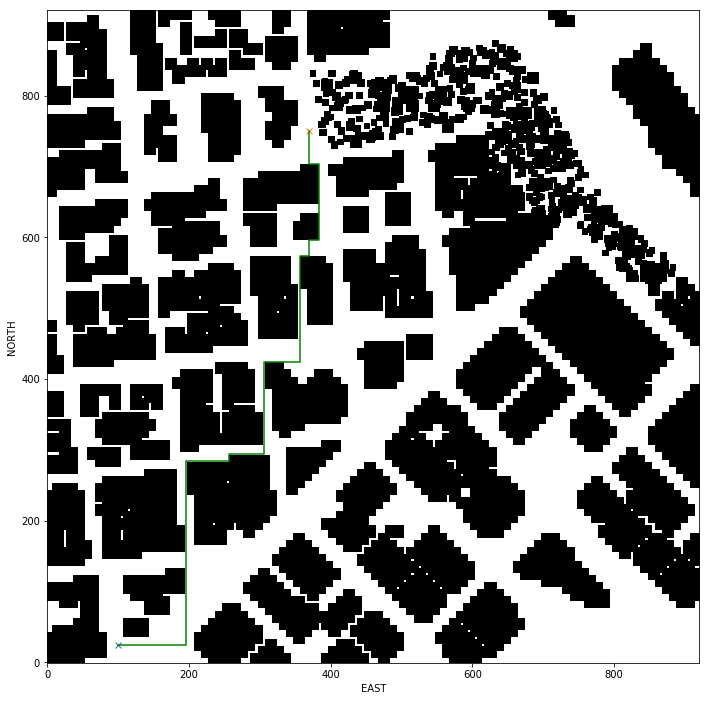

In [25]:
plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

if path is not None:
    pp = np.array(path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Pretty neat! Unfortunately this path is impractical, the drone would be constantly stopping and going since each grid cell visited is synonymous with a waypoint. Ideally, we'd like to only consider a new waypoint when the drone's direction changes. Path pruning is one way to achieve this result.

### Path Pruning

In [26]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

Complete the `prune_path` function below. It should return a new path much shorter than the original.

In [39]:
def window(iterable, size=2):
    i = iter(iterable)
    win = []
    for e in range(0, size):
        win.append(next(i))
    yield win
    for e in i:
        win = win[1:] + [e]
        yield win


def prune_path(path):
    if path is not None:
        pruned_path = []
        for i, three_points in enumerate(window(path, 3)):
            print(i, three_points)
            if i == 0:
                pruned_path.append(three_points[0])
                pruned_path.append(three_points[1])
                pruned_path.append(three_points[2])
            else:
                _p1 = point(three_points[0])
                _p2 = point(three_points[1])
                _p3 = point(three_points[2])
                if collinearity_check(_p1, _p2, _p3):
                    pruned_path.pop()
                    pruned_path.append(three_points[2])
                else:
                    pruned_path.append(three_points[2])
    else:
        pruned_path = path
        
    return pruned_path

Prune the path.

In [40]:
pruned_path = prune_path(path)
print(pruned_path)

0 [(25, 100), (25, 101), (25, 102)]
1 [(25, 101), (25, 102), (25, 103)]
2 [(25, 102), (25, 103), (25, 104)]
3 [(25, 103), (25, 104), (25, 105)]
4 [(25, 104), (25, 105), (25, 106)]
5 [(25, 105), (25, 106), (25, 107)]
6 [(25, 106), (25, 107), (25, 108)]
7 [(25, 107), (25, 108), (25, 109)]
8 [(25, 108), (25, 109), (25, 110)]
9 [(25, 109), (25, 110), (25, 111)]
10 [(25, 110), (25, 111), (25, 112)]
11 [(25, 111), (25, 112), (25, 113)]
12 [(25, 112), (25, 113), (25, 114)]
13 [(25, 113), (25, 114), (25, 115)]
14 [(25, 114), (25, 115), (25, 116)]
15 [(25, 115), (25, 116), (25, 117)]
16 [(25, 116), (25, 117), (25, 118)]
17 [(25, 117), (25, 118), (25, 119)]
18 [(25, 118), (25, 119), (25, 120)]
19 [(25, 119), (25, 120), (25, 121)]
20 [(25, 120), (25, 121), (25, 122)]
21 [(25, 121), (25, 122), (25, 123)]
22 [(25, 122), (25, 123), (25, 124)]
23 [(25, 123), (25, 124), (25, 125)]
24 [(25, 124), (25, 125), (25, 126)]
25 [(25, 125), (25, 126), (25, 127)]
26 [(25, 126), (25, 127), (25, 128)]
27 [(25, 12

In [41]:
pruned_path

[(25, 100),
 (25, 101),
 (25, 196),
 (284, 196),
 (284, 256),
 (294, 256),
 (294, 306),
 (424, 306),
 (424, 356),
 (574, 356),
 (574, 370),
 (596, 370),
 (596, 384),
 (704, 384),
 (704, 370),
 (750.0, 370.0)]

Replot the path, it will be the same as before but the drone flight will be much smoother.

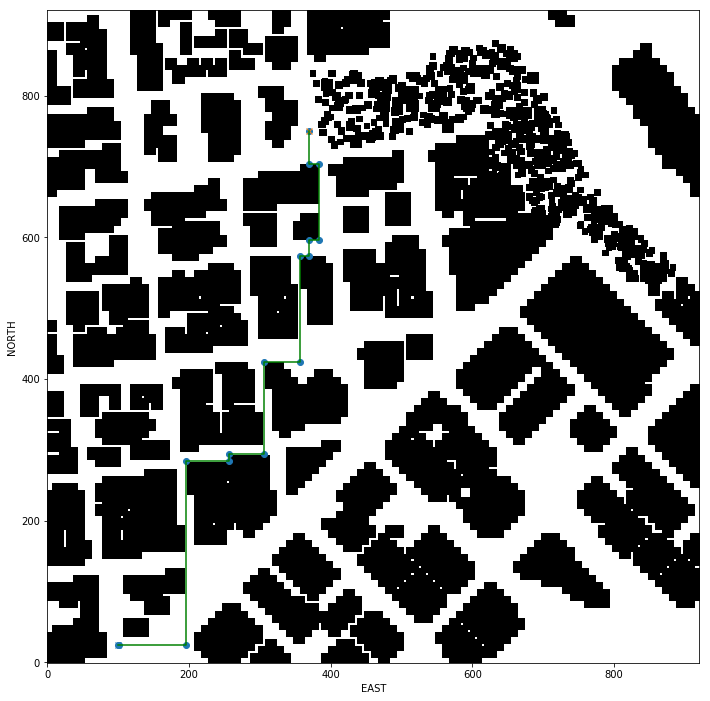

In [42]:
plt.imshow(grid, cmap='Greys', origin='lower')

plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

if pruned_path is not None:
    pp = np.array(pruned_path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')
    plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

Now the waypoints symbolize a change in direction, much better!

[solution](/notebooks/A-Star-City-Solution.ipynb)